<a href="https://colab.research.google.com/github/Clement-Okolo/ImageProcessing/blob/main/Image%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification

I implemented a model for cat versus dog image classification using transfer learning by utilizing the ResNet network. The ResNet model  I developed is trained using a up to 5,000 training samples and tested on atleast 500 test samples. Then, I compared different aspects of the model, such as one-layer vs. two-layer classification and data augmentation vs. no data augmentation. This flexibility allows for a comprehensive analysis of the model's performance under different configurations.

# Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import resnet50
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.applications import ResNet50, InceptionV3
import numpy as np
from numpy import mean, std
from matplotlib import pyplot
import os
import pandas as pd

In [ ]:
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.10/dist-packages/tensorflow/_api/v2/version/__init__.py'>


# Load Dataset

In [ ]:
! pip install kaggle # install kaggle python library

from google.colab import drive # mount google drive
drive.mount('/content/drive')

! mkdir ~/.kaggle # make a directory for kaggle at the temporary instance location on Colab drive
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/ # copy json file to temporary loacation
! chmod 600 ~/.kaggle/kaggle.json # change file permission to read/write by owner only

Mounted at /content/drive


In [ ]:
! kaggle competitions download dogs-vs-Cats # download dataset

! unzip dogs-vs-Cats.zip # unzip datasets
! unzip test1.zip # unzip train data
! unzip train.zip # unzip test data

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [ ]:
# List all filenames in the actual extracted directory
filenames = os.listdir("/content/train")

# Separate filenames into cats and dogs
cat_images = [filename for filename in filenames if "cat" in filename]
dog_images = [filename for filename in filenames if "dog" in filename]

# Get the count of each class
cat_count = len(cat_images)
dog_count = len(dog_images)

# Centralize Dataset

In [ ]:
#In this step,I am going to centralize the dataset's information into a DataFrame. This makes it easier to manage and process the data in the subsequent steps

df_cat = pd.DataFrame({
    'filename': cat_images,
    'label': 'cat',
})
df_dog = pd.DataFrame({
    'filename': dog_images,
    'label': 'dog',
})


df = pd.concat([df_cat, df_dog])

df.head()


,filename,label
0,cat.10986.jpg,cat
1,cat.9206.jpg,cat
2,cat.8483.jpg,cat
3,cat.2554.jpg,cat
4,cat.8191.jpg,cat


# Use up to 5,000 training samples and at least 500 test samples

# Set Training and Test Data

In [ ]:
np.random.seed(42) # set random seed for reproducibility

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df,test_size=0.2, random_state=24)

In [ ]:
train_data_path='/content/train'
BATCH_SIZE = 250
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
CHANNEL = 3
EPOCHS = 2

#Data Augmentation

In [ ]:
train_data_gen=ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,rescale=1./255.,
                                   zoom_range=0.3,fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1./255,horizontal_flip=False)

# Create Data Generator

In [ ]:
# Create train Data Generator
train_generator = train_data_gen.flow_from_dataframe(dataframe=train_df,
                                                     directory=train_data_path,
                                                     x_col='filename',
                                                     y_col='label',
                                                     target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                                                     color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                     class_mode='binary')

# Create Test Data Generator
test_generator = test_data_gen.flow_from_dataframe(dataframe=train_df,
                                                   directory=train_data_path,
                                                   x_col='filename',
                                                     y_col='label',
                                                   target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                                                     color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                   class_mode='binary')


Found 20000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


#Plot Original and Augmented Images

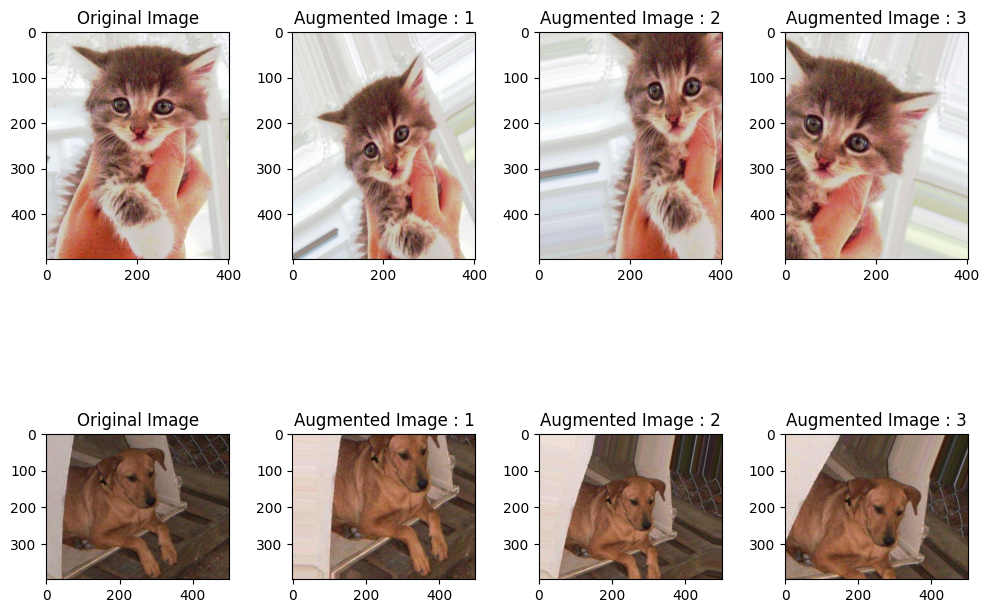

In [ ]:
from keras.utils import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt

img = load_img('train/cat.100.jpg')
img2 = load_img('train/dog.100.jpg')

x = img_to_array(img)
x = np.expand_dims(x, axis=0)

x1 = img_to_array(img2)
x1 = np.expand_dims(x1, axis=0)

fig, axis = plt.subplots(2,4, figsize=(10,8))
#fig2, axis2 = plt.subplots(1,5, figsize=(10,8))

axis[0,0].imshow(img)
axis[0,0].set_title('Original Image')
axis[1,0].imshow(img2)
axis[1,0].set_title('Original Image')

i = 1
for batch in train_data_gen.flow(x, batch_size=1):
    axis[0,i].imshow(array_to_img(batch[0]))
    axis[0,i].set_title('Augmented Image : '+str(i))
    i += 1
    if i % 4 == 0:
        break
j=1
for batch in train_data_gen.flow(x1, batch_size=1):
    axis[1,j].imshow(array_to_img(batch[0]))
    axis[1,j].set_title('Augmented Image : '+str(j))
    j += 1
    if j % 4 == 0:
        break
plt.tight_layout()
plt.show()

# Class Labels and Class Name

In [ ]:
class_indices = train_generator.class_indices

class_labels = {v: k for k, v in class_indices.items()}
for label, value in class_labels.items():
    print(f"Class Label: {label}, Class Name: {value}")

Class Label: 0, Class Name: cat
Class Label: 1, Class Name: dog


# Create Checkpoint to Avoid Unnecessary Training Based on Validation Accuracy

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1, restore_best_weights=True)

# ResNet Model with 1-layer and Data Augmentation

In [ ]:
from keras.applications import ResNet50, InceptionV3

# Load the ResNet50 model pre-trained on Imagnet data, excluding the top classifier
base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output # pre-trained model's output
x=  MaxPooling2D()(x) # add MaxPooling layer to reduce the spaitial dimensions of the feature maps and to make model less to overfitting
x = Dropout(0.2)(x) # add a dropout layer for regularization
x = Flatten()(x) # flattens the tensor (x) into a one-dimensional vector

output = Dense(1, activation="sigmoid")(x)
model_final = Model(inputs=base_model.input, outputs=output)
model_final.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
print(model_final.summary()) # examine our final ResNet model summary to understand the number of parameters involved

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

# Model Performance Assessment

In [ ]:
try:
    with tf.device('/device:GPU:2'):
        result = model_final.fit(train_generator,
                                 epochs=EPOCHS,
                                 validation_data=test_generator,
                                 callbacks=[checkpoint_callback,
                                            stopping_callback])
except RuntimeError as e:
    print(e)

Epoch 1/2
80/80 [==============================] - ETA: 0s - loss: 0.7859 - accuracy: 0.5436
Epoch 1: val_accuracy improved from -inf to 0.64315, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 419s 5s/step - loss: 0.7859 - accuracy: 0.5436 - val_loss: 0.6338 - val_accuracy: 0.6431
Epoch 2/2
80/80 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.5759
Epoch 2: val_accuracy improved from 0.64315 to 0.65515, saving model to best_model.h5
80/80 [==============================] - 430s 5s/step - loss: 0.7005 - accuracy: 0.5759 - val_loss: 0.6230 - val_accuracy: 0.6551


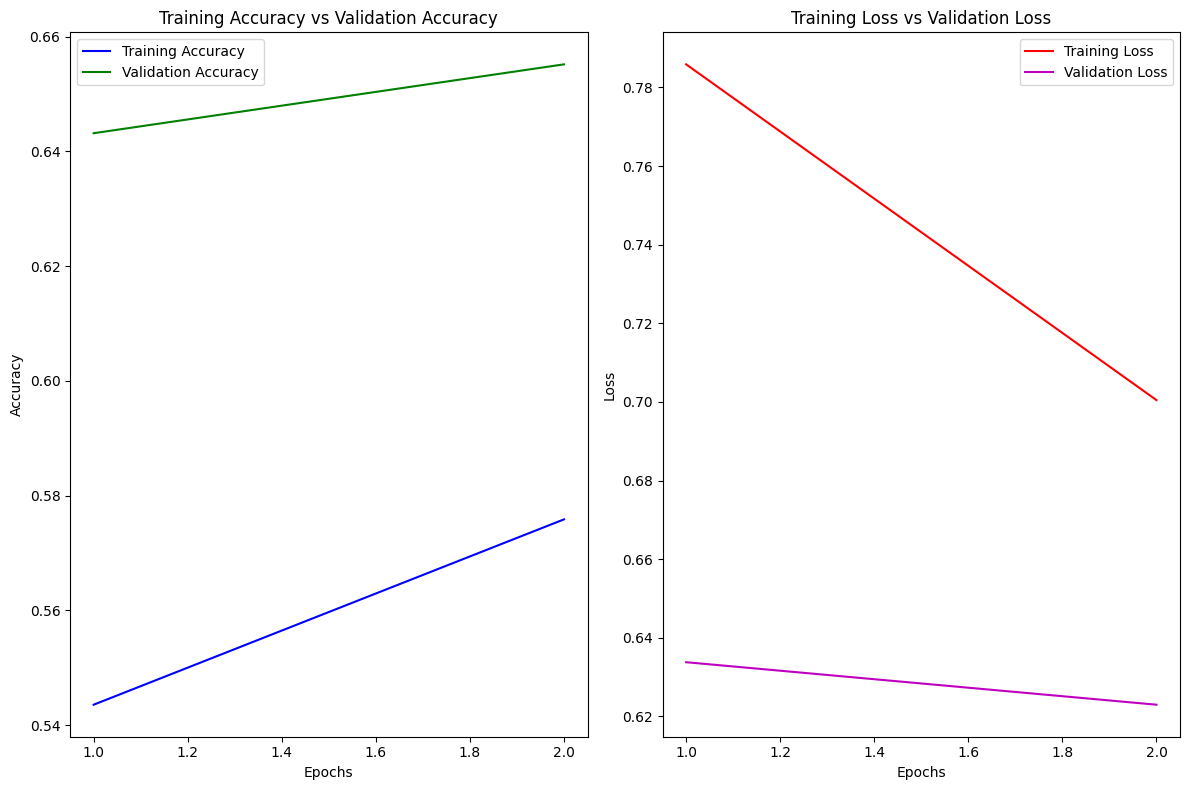

In [ ]:

def plot_result(accuracy, val_accuracy, loss, val_loss,file_name_to_save):
    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 8))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'm', label='Validation Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_result(result.history['accuracy'],result.history['val_accuracy'],result.history['loss'],result.history['val_loss'],
            'model_with_two_layer_data_augmentation.png')

# ResNet Model with 2-Layers and Data Augumentation

In [ ]:
from keras.applications import ResNet50, InceptionV3

base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output # pre-trained model
x=  MaxPooling2D()(x) # add MaxPooling layer to reduce spatial dimensions of the feature maps
x = Dropout(0.2)(x) # add a dropout layer for regularization
x = Flatten()(x) # flattens the tensor (x) to 1-dimensional vector
x = Dense(1024, activation="sigmoid")(x) # uncomment when creating a model with two layers
output = Dense(1, activation="sigmoid")(x)
model_final = Model(inputs=base_model.input, outputs=output)
model_final.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
print(model_final.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

# Model Performance Assessment

In [ ]:
try:
    with tf.device('/device:GPU:2'):
        result = model_final.fit(train_generator,
                                 #steps_per_epoch=5000 // BATCH_SIZE,
                                 epochs=EPOCHS,
                                 validation_data=test_generator,
                                 #validation_steps=500 // BATCH_SIZE,
                                 callbacks=[checkpoint_callback,
                                            stopping_callback])
except RuntimeError as e:
    print(e)

Epoch 1/2
80/80 [==============================] - ETA: 0s - loss: 1.0899 - accuracy: 0.4955
Epoch 1: val_accuracy did not improve from 0.65515
80/80 [==============================] - 395s 5s/step - loss: 1.0899 - accuracy: 0.4955 - val_loss: 0.6916 - val_accuracy: 0.5090
Epoch 2/2
80/80 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.5653
Epoch 2: val_accuracy did not improve from 0.65515
80/80 [==============================] - 408s 5s/step - loss: 0.6829 - accuracy: 0.5653 - val_loss: 0.6643 - val_accuracy: 0.6133


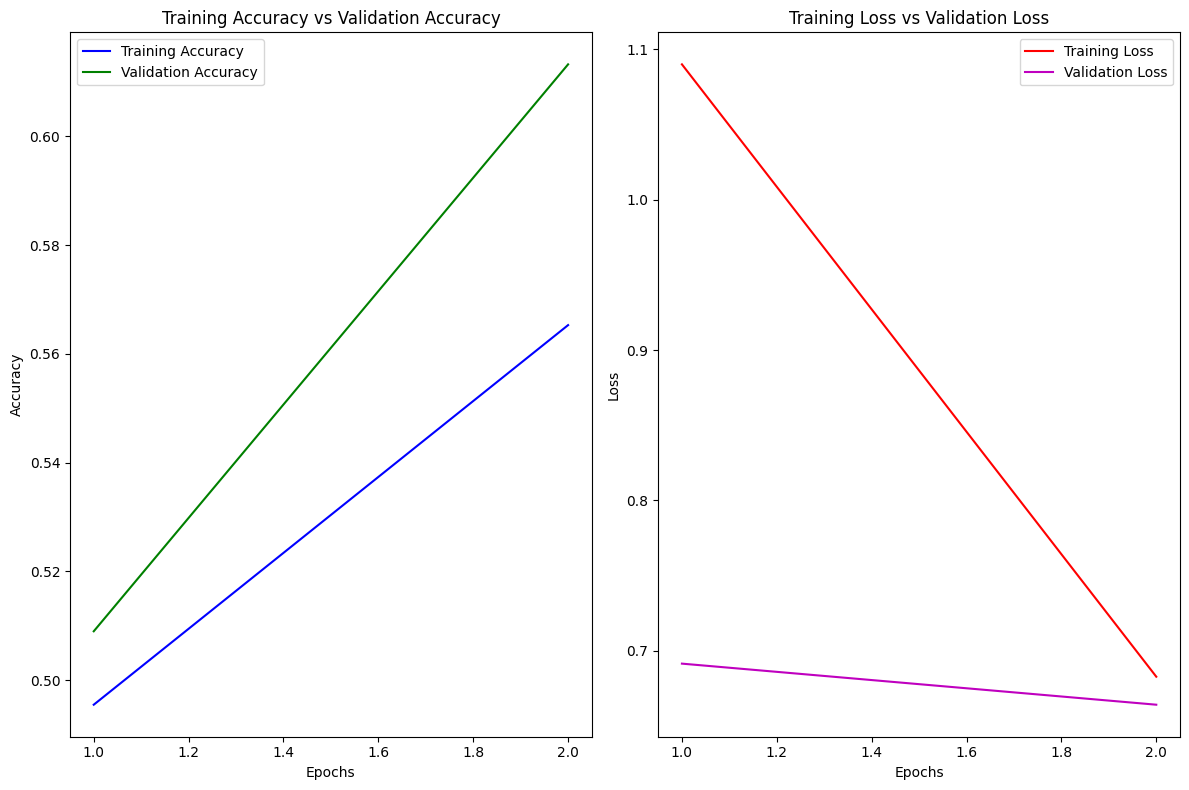

In [ ]:

def plot_result(accuracy, val_accuracy, loss, val_loss,file_name_to_save):
    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 8))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'm', label='Validation Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_result(result.history['accuracy'],result.history['val_accuracy'],result.history['loss'],result.history['val_loss'],
            'model_with_two_layer_data_augmentation.png')

# ResNet Model with 1-Layer and without Data Augumentation

In [ ]:
#train_data_gen=ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,rescale=1./255.,
                                   #zoom_range=0.3,fill_mode='nearest')
#test_data_gen = ImageDataGenerator(rescale=1./255,horizontal_flip=False)

train_data_gen=ImageDataGenerator() # Used for no data augmentation
test_data_gen = ImageDataGenerator() # Used for no data augmentation

**Create Data Generator**

In [ ]:
# Create train Data Generator
train_generator = train_data_gen.flow_from_dataframe(dataframe=train_df,
                                                     directory=train_data_path,
                                                     x_col='filename',
                                                     y_col='label',
                                                     target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                                                     color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                     class_mode='binary')

# Create Test Data Generator
test_generator = test_data_gen.flow_from_dataframe(dataframe=train_df,
                                                   directory=train_data_path,
                                                   x_col='filename',
                                                     y_col='label',
                                                   target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                                                     color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                   class_mode='binary')


Found 20000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
class_indices = train_generator.class_indices

class_labels = {v: k for k, v in class_indices.items()}
for label, value in class_labels.items():
    print(f"Class Label: {label}, Class Name: {value}")

Class Label: 0, Class Name: cat
Class Label: 1, Class Name: dog


In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1, restore_best_weights=True)

In [ ]:
from keras.applications import ResNet50, InceptionV3

base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x=  MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
#x = Dense(1024, activation="sigmoid")(x) # uncommented when create model with two layers
output = Dense(1, activation="sigmoid")(x)
model_final = Model(inputs=base_model.input, outputs=output)
model_final.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
print(model_final.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

# Model Performance Assessment

In [ ]:
try:
    with tf.device('/device:GPU:2'):
        result = model_final.fit(train_generator,
                                 #steps_per_epoch=5000 // BATCH_SIZE,
                                 epochs=EPOCHS,
                                 validation_data=test_generator,
                                 #validation_steps=500 // BATCH_SIZE,
                                 callbacks=[checkpoint_callback,
                                            stopping_callback])
except RuntimeError as e:
    print(e)

Epoch 1/2
80/80 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.9299
Epoch 1: val_accuracy improved from -inf to 0.97930, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 161s 2s/step - loss: 0.4449 - accuracy: 0.9299 - val_loss: 0.0907 - val_accuracy: 0.9793
Epoch 2/2
80/80 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9753
Epoch 2: val_accuracy improved from 0.97930 to 0.98685, saving model to best_model.h5
80/80 [==============================] - 142s 2s/step - loss: 0.1061 - accuracy: 0.9753 - val_loss: 0.0439 - val_accuracy: 0.9869


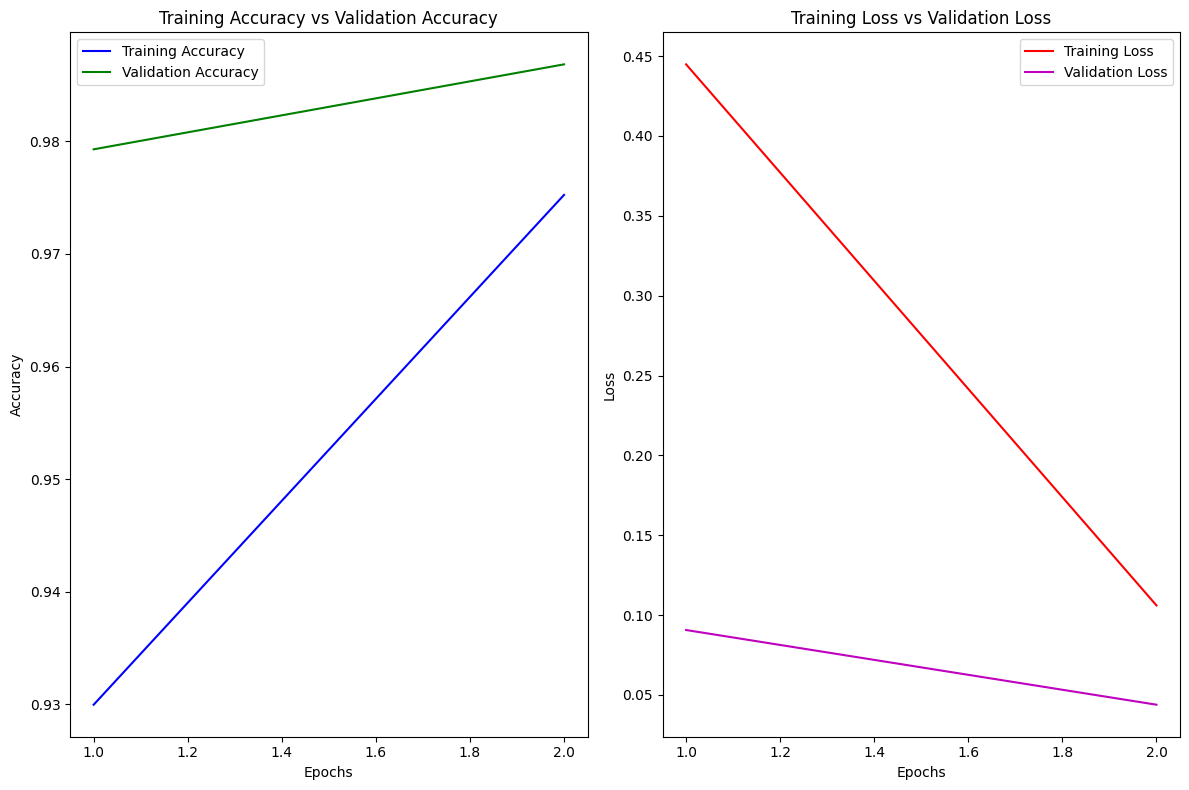

In [ ]:

def plot_result(accuracy, val_accuracy, loss, val_loss,file_name_to_save):
    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 8))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'm', label='Validation Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_result(result.history['accuracy'],result.history['val_accuracy'],result.history['loss'],result.history['val_loss'],
            'model_with_two_layer_data_augmentation.png')

# ResNet Model with 2-Layers and without Data Augumentation

In [ ]:
from keras.applications import ResNet50, InceptionV3

base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x=  MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation="sigmoid")(x) # uncommented when create model with two layers
output = Dense(1, activation="sigmoid")(x)
model_final = Model(inputs=base_model.input, outputs=output)
model_final.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
print(model_final.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

# Model Performance Assessment

In [ ]:
try:
    with tf.device('/device:GPU:2'):
        result = model_final.fit(train_generator,
                                 #steps_per_epoch=5000 // BATCH_SIZE,
                                 epochs=EPOCHS,
                                 validation_data=test_generator,
                                 #validation_steps=500 // BATCH_SIZE,
                                 callbacks=[checkpoint_callback,
                                            stopping_callback])
except RuntimeError as e:
    print(e)

Epoch 1/2
80/80 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9466
Epoch 1: val_accuracy did not improve from 0.98685
80/80 [==============================] - 161s 2s/step - loss: 0.2193 - accuracy: 0.9466 - val_loss: 0.0634 - val_accuracy: 0.9764
Epoch 2/2
80/80 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9780
Epoch 2: val_accuracy did not improve from 0.98685
80/80 [==============================] - 156s 2s/step - loss: 0.0596 - accuracy: 0.9780 - val_loss: 0.0517 - val_accuracy: 0.9833


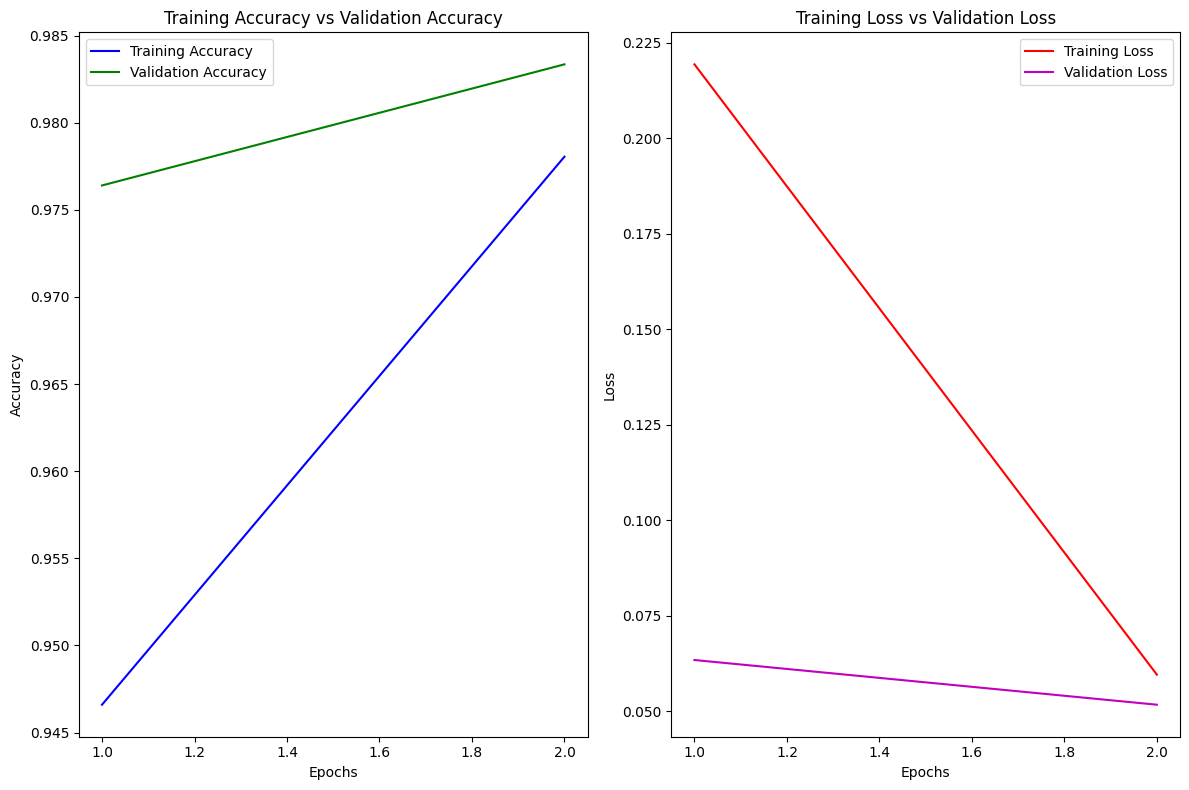

In [ ]:

def plot_result(accuracy, val_accuracy, loss, val_loss,file_name_to_save):
    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 8))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'm', label='Validation Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_result(result.history['accuracy'],result.history['val_accuracy'],result.history['loss'],result.history['val_loss'],
            'model_with_two_layer_data_augmentation.png')

In [ ]:
# prompt:

import tensorflow as tf
from tensorflow import keras
from keras.applications import resnet50
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.applications import ResNet50, InceptionV3
import numpy as np
from numpy import mean, std
from matplotlib import pyplot
import os
import pandas as pd
from google.colab import drive # mount google drive
from sklearn.model_selection import train_test_split
from keras.utils import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
class_indices = train_generator.class_indices

class_labels = {v: k for k, v in class_indices.items()}
for label, value in class_labels.items():
    print(f"Class Label: {label}, Class Name: {value}")
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1, restore_best_weights=True)

base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x=  MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation="sigmoid")(x) # uncommented when create model with two layers
output = Dense(1, activation="sigmoid")(x)
model_final = Model(inputs=base_model.input, outputs=output)
model_final.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model_final.summary())
# # Model Performance Assessment
try:
    with tf.device('/device:GPU:2'):
        result = model_final.fit(train_generator,
                                 #steps_per_epoch=5000 // BATCH_SIZE,
                                 epochs=EPOCHS,
                                 validation_data=test_generator,
                                 #validation_steps=500 // BATCH_SIZE,
                                 callbacks=[checkpoint_callback,
                                            stopping_callback])
except RuntimeError as e:
    print(e)

def plot_result(accuracy, val_accuracy, loss, val_loss,file_name_to_save):
    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 8))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'm', label='Validation Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_result(result.history['accuracy'],result.history['val_accuracy'],result.history['loss'],result.history['val_loss'],
            'model_with_two_layer_data_augmentation.png')
